In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pyTelegramBotAPI

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.9/222.9 kB 20.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyTelegramBotAPI: filename=pyTelegramBotAPI-4.10.0-py3-none-any.whl size=205421 sha256=41f6ff554e7d48b75ffa88e414ef81a98b7c8ad158586bdfd0ee94a08b0e089f
  Stored in directory: /root/.cache/pip/wheels/ef/ba/4b/187be68f61aa7818b28d8b21200d130fd35ba36f002efcc262
Successfully built pyTelegramBotAPI


In [ ]:
import cv2
import telebot

In [ ]:
TOKEN='yours TOKEN'
bot = telebot.TeleBot(TOKEN)

In [ ]:
# импортируем нужные модули
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import PIL
import time

In [ ]:
# скопируем репозиторий darknet 
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15514, done.
remote: Total 15514 (delta 0), reused 0 (delta 0), pack-reused 15514
Receiving objects: 100% (15514/15514), 14.17 MiB | 16.51 MiB/s, done.
Resolving deltas: 100% (10412/10412), done.


In [ ]:
# изменим кое-какие настройки
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile

/content/darknet


In [ ]:
# соберем получившееся решение, чтобы запускать файл darknet.py 
!make

In [ ]:
# скачаем файл весов модели yolov4, натренированный определять 80 классов объектов 
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq" -O yolov4-csp.weights && rm -rf /tmp/cookies.txt

In [ ]:
# импортируем darknet функции для детектирования объектов
from darknet import *
# загрузим YOLOv4 
network, class_names, class_colors = load_network("cfg/yolov4-csp.cfg", "cfg/coco.data", "yolov4-csp.weights")
width = network_width(network)
height = network_height(network)
# darknet_helper функция для детектирования объектов на изображении
def darknet_helper(img, width, height):
  darknet_image = make_image(width, height, 3)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_resized = cv2.resize(img_rgb, (width, height), interpolation=cv2.INTER_LINEAR)
  # пересчет координат границ объектов, чтобы можно было отобразить на кадре
  img_height, img_width, _ = img.shape
  width_ratio = img_width/width
  height_ratio = img_height/height
  # запуск модели
  copy_image_from_bytes(darknet_image, img_resized.tobytes())
  detections = detect_image(network, class_names, darknet_image)
  free_image(darknet_image)
  return detections, width_ratio, height_ratio

In [ ]:
@bot.message_handler(content_types=['photo'])# виды сообщений хендлеров описаны в документации
def photographio(message):
  print(message)
  file = bot.get_file(message.photo[-1].file_id)
  bot.send_message(message.from_user.id, 'Фото получил. Обрабатываю!')
  dfile = bot.download_file(file.file_path)
  fimg = message.photo[-1].file_id + '.png'
  with open(fimg, 'wb') as new_file:
     new_file.write(dfile)
  new_file.close()# с with open вроде как отдельно закрывать не нужно.
  img = cv2.imread(fimg)
  detections, width_ratio, height_ratio = darknet_helper(img, width, height) 

  for label, confidence, bbox in detections:
    left, top, right, bottom = bbox2points(bbox)
    left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
    cv2.rectangle(img, (left, top), (right, bottom), class_colors[label], 2)
    cv2.putText(img, "{} [{:.2f}]".format(label, float(confidence)), (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, class_colors[label], 2)
  
  cv2.imwrite(fimg, img)
  with open(fimg,'rb') as fil:
        byte = fil.read()
  print('отправлено')
  bot.send_photo(message.from_user.id,  byte)

bot.infinity_polling()

{'content_type': 'photo', 'id': 19, 'message_id': 19, 'from_user': {'id': 811097090, 'is_bot': False, 'first_name': 'Максим', 'username': 'xammax1', 'last_name': None, 'language_code': 'ru', 'can_join_groups': None, 'can_read_all_group_messages': None, 'supports_inline_queries': None, 'is_premium': None, 'added_to_attachment_menu': None}, 'date': 1681213586, 'chat': {'id': 811097090, 'type': 'private', 'title': None, 'username': 'xammax1', 'first_name': 'Максим', 'last_name': None, 'is_forum': None, 'photo': None, 'bio': None, 'join_to_send_messages': None, 'join_by_request': None, 'has_private_forwards': None, 'has_restricted_voice_and_video_messages': None, 'description': None, 'invite_link': None, 'pinned_message': None, 'permissions': None, 'slow_mode_delay': None, 'message_auto_delete_time': None, 'has_protected_content': None, 'sticker_set_name': None, 'can_set_sticker_set': None, 'linked_chat_id': None, 'location': None, 'active_usernames': None, 'emoji_status_custom_emoji_id': 

2023-04-11 11:57:29,677 (__init__.py:966 MainThread) ERROR - TeleBot: "Infinity polling: polling exited"
ERROR:TeleBot:Infinity polling: polling exited
2023-04-11 11:57:29,680 (__init__.py:968 MainThread) ERROR - TeleBot: "Break infinity polling"
ERROR:TeleBot:Break infinity polling


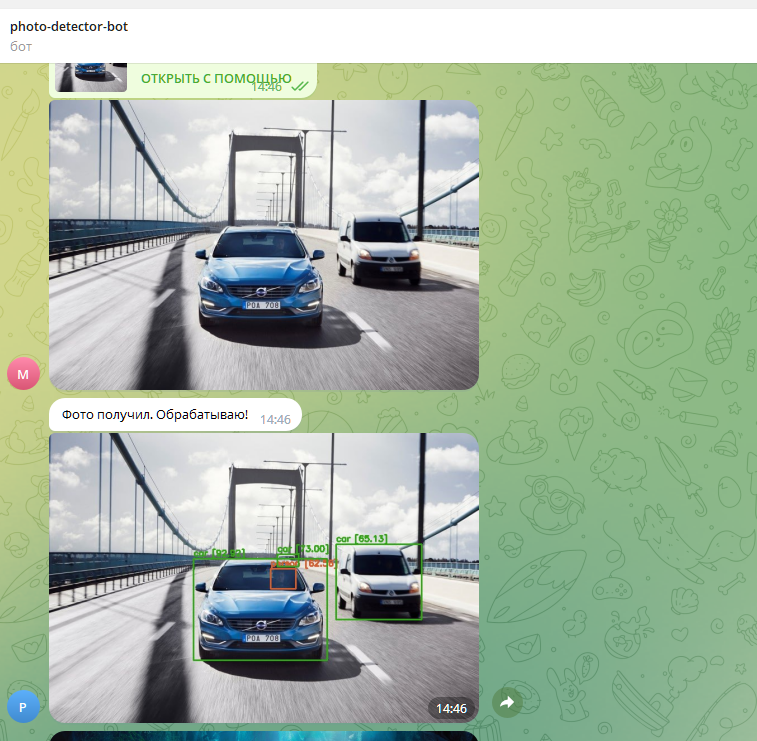

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
image = Image.open('/content/drive/MyDrive/image_2023-04-29_16-32-06.png')
image